In [1]:
%load_ext autoreload
%autoreload 2

# Download OTG 210608 L2G mappings

In [2]:
import gc
import json
import time
from ftplib import FTP
from pathlib import Path
from urllib.request import urlopen

import numpy as np
import scipy as sp
import scipy.sparse as spp
import scanpy as sc

from tqdm.auto import tqdm
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt

from pyannotables import tables

In [3]:
import genetics

In [4]:
pd.set_option('display.max_columns', None)

## Fetch study JSON files from FTP

In [5]:
url_root = 'ftp.ebi.ac.uk'
json_dir = '/pub/databases/opentargets/genetics/210608/lut/study-index'

ftp = FTP(url_root)
ftp.login()
ftp.cwd(json_dir)

files = []
cb = lambda x: files.append(x.split()[8]) if "SUCCESS" not in x else None

code = ftp.retrlines('LIST', callback=cb)

In [6]:
files[:5]

['part-00000-7e851255-3224-4792-8c77-5ad68c417102-c000.json',
 'part-00001-7e851255-3224-4792-8c77-5ad68c417102-c000.json',
 'part-00002-7e851255-3224-4792-8c77-5ad68c417102-c000.json',
 'part-00003-7e851255-3224-4792-8c77-5ad68c417102-c000.json',
 'part-00004-7e851255-3224-4792-8c77-5ad68c417102-c000.json']

## Parse study JSON files

In [7]:
studies = []

for f in tqdm(files):

    file_url = f'ftp://{url_root}{json_dir}/{f}'
    json_url = urlopen(file_url, timeout=10)
    df = json_normalize([json.loads(x.decode('utf-8')) for x in json_url.readlines()])
    studies.append(df)
    
studies = pd.concat(studies, axis=0).reset_index(drop=True)

  0%|          | 0/57 [00:00<?, ?it/s]

In [8]:
studies.shape

(33781, 17)

In [9]:
studies = studies[studies.num_assoc_loci>0]
studies.shape

(17054, 17)

In [10]:
studies.head()

,study_id,pub_date,pub_author,trait_reported,ancestry_initial,ancestry_replication,n_initial,n_replication,n_cases,num_assoc_loci,has_sumstats,source,trait_efos,trait_category,pmid,pub_journal,pub_title
5,FINNGEN_R5_AB1_BACTINF_NOS,2021-05-11,FINNGEN_R5,"""Bacterial infection, other or unspecified""",[European=218637],[],218637,0.0,20977.0,2,True,FINNGEN,[EFO_0000771],infectious disease,NaN,NaN,NaN
12,FINNGEN_R5_AB1_DERMATOPHYTOSIS,2021-05-11,FINNGEN_R5,Dermatophytosis,[European=216472],[],216472,0.0,1656.0,1,True,FINNGEN,[MONDO_0004678],infectious disease,NaN,NaN,NaN
14,FINNGEN_R5_AB1_EBV,2021-05-11,FINNGEN_R5,Infectious mononucleosis,[European=214904],[],214904,0.0,1238.0,1,True,FINNGEN,[EFO_0007326],infectious disease,NaN,NaN,NaN
16,FINNGEN_R5_AB1_GASTROENTERITIS_NOS,2021-05-11,FINNGEN_R5,Diarrhoea and gastroenteritis of presumed infe...,[European=212553],[],212553,0.0,15255.0,1,True,FINNGEN,[MONDO_0045031],infectious disease,NaN,NaN,NaN
17,FINNGEN_R5_AB1_GHLAMY_OTHER,2021-05-11,FINNGEN_R5,Other diseases caused by chlamydiae,[European=218772],[],218772,0.0,167.0,1,True,FINNGEN,[EFO_1001288],infectious disease,NaN,NaN,NaN


In [11]:
studies.trait_reported.nunique()

14384

In [12]:
studies.trait_efos.astype(str).nunique()

3925

## Fetch study and variant info through GraphQL

In [13]:
all_studies = sorted(list(set(studies.study_id.tolist())))

In [14]:
len(all_studies)

17054

In [15]:
chunk_size = 10
split_studies = np.array_split(all_studies, len(all_studies)//chunk_size)

In [16]:
api = genetics.Genetics()

In [17]:
len(split_studies[0])

11

In [18]:
split_studies[0][0]

'FINNGEN_R5_AB1_BACTINF_NOS'

In [19]:
api.study_info([split_studies[0][0]])

,studyId,traitReported,source,traitEfos,pmid,pubDate,pubJournal,pubTitle,pubAuthor,hasSumstats,ancestryInitial,ancestryReplication,nInitial,nReplication,nCases,traitCategory,numAssocLoci,nTotal
0,FINNGEN_R5_AB1_BACTINF_NOS,"""Bacterial infection, other or unspecified""",FINNGEN,[EFO_0000771],None,2021-05-11,None,None,FINNGEN_R5,True,[European=218637],[],218637,0,20977,infectious disease,2,218637


In [20]:
split_studies[0][:10]

array(['FINNGEN_R5_AB1_BACTINF_NOS', 'FINNGEN_R5_AB1_DERMATOPHYTOSIS',
       'FINNGEN_R5_AB1_EBV', 'FINNGEN_R5_AB1_GASTROENTERITIS_NOS',
       'FINNGEN_R5_AB1_GHLAMY_OTHER', 'FINNGEN_R5_AB1_MALARIA',
       'FINNGEN_R5_AB1_MEASLES', 'FINNGEN_R5_AB1_OTHER_BACTERIAL',
       'FINNGEN_R5_AB1_OTHER_CHLAMYDIAE',
       'FINNGEN_R5_AB1_OTHER_SPIROCHAETAL'], dtype='<U113')

In [21]:
df = api.manhattan(split_studies[0][:10])
df

,bestGenes,bestColocGenes,bestLocus2Genes,pvalMantissa,pvalExponent,credibleSetSize,ldSetSize,totalSetSize,pval,oddsRatio,oddsRatioCILower,oddsRatioCIUpper,beta,betaCILower,betaCIUpper,direction,variant_chromosome,variant_position,variant_refAllele,variant_altAllele,variant_rsId,variant_chromosomeB37,variant_positionB37,variant_id,variant_nearestGene_id,variant_nearestGene_symbol,variant_nearestGene_bioType,variant_nearestGene_description,variant_nearestGene_chromosome,variant_nearestGene_tss,variant_nearestGene_start,variant_nearestGene_end,variant_nearestGene_fwdStrand,variant_nearestGene_exons,variant_nearestGeneDistance,variant_nearestCodingGene_id,variant_nearestCodingGene_symbol,variant_nearestCodingGene_bioType,variant_nearestCodingGene_description,variant_nearestCodingGene_chromosome,variant_nearestCodingGene_tss,variant_nearestCodingGene_start,variant_nearestCodingGene_end,variant_nearestCodingGene_fwdStrand,variant_nearestCodingGene_exons,variant_nearestCodingGeneDistance,variant_mostSevereConsequence,variant_caddRaw,variant_caddPhred,variant_gnomadAFR,variant_gnomadAMR,variant_gnomadASJ,variant_gnomadEAS,variant_gnomadFIN,variant_gnomadNFE,variant_gnomadNFEEST,variant_gnomadNFENWE,variant_gnomadNFESEU,variant_gnomadNFEONF,variant_gnomadOTH,study,variant_nearestGene,variant_nearestCodingGene
0,"[{'gene': {'id': 'ENSG00000132693', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000132693', 'symbol': ...",7.347,-10,3,4,4,7.347000e-10,8.750275e-01,8.386280e-01,9.130068e-01,None,None,None,-,1,159743672,A,G,rs74596724,1,159713462,1_159743672_A_G,ENSG00000132693,CRP,protein_coding,C-reactive protein [Source:HGNC Symbol;Acc:HGN...,1,159714589.0,159712289.0,159714589.0,False,"[159714425, 159714589, 159712289, 159714138]",29083,ENSG00000132693,CRP,protein_coding,C-reactive protein [Source:HGNC Symbol;Acc:HGN...,1,159714589.0,159712289.0,159714589.0,False,"[159714425, 159714589, 159712289, 159714138]",29083,intergenic_variant,0.770176,11.64,0.011703,0.040094,0.096552,0.164103,0.063364,0.075765,0.096288,0.067939,0.09434,0.062324,0.0625,FINNGEN_R5_AB1_BACTINF_NOS,NaN,NaN
1,"[{'gene': {'id': 'ENSG00000235532', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000118922', 'symbol': ...",4.621,-8,8,0,8,4.621000e-08,1.994114e+00,1.556870e+00,2.554158e+00,None,None,None,+,13,74291635,C,T,rs117832616,13,74865772,13_74291635_C_T,ENSG00000235532,LINC00402,lincRNA,long intergenic non-protein coding RNA 402 [So...,13,74231457.0,74231457.0,74259976.0,True,"[74256933, 74259976, 74231457, 74231752]",60178,ENSG00000118922,KLF12,protein_coding,Kruppel like factor 12 [Source:HGNC Symbol;Acc...,13,73995056.0,73686089.0,73995056.0,False,"[73686089, 73695671, 73715368, 73715525, 73764...",296579,upstream_gene_variant,-0.24534,0.528,0,0.002358,0,0.010296,0.003165,0.000519,0.001093,0.000116,0,0.000935,0,FINNGEN_R5_AB1_BACTINF_NOS,NaN,NaN
2,"[{'gene': {'id': 'ENSG00000135336', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000118434', 'symbol': ...",1.263,-8,27,60,63,1.263000e-08,1.350399e+00,1.217672e+00,1.497592e+00,None,None,None,+,6,87971973,T,C,rs2474884,6,88681691,6_87971973_T_C,ENSG00000118434,SPACA1,protein_coding,sperm acrosome associated 1 [Source:HGNC Symbo...,6,88047841.0,88047841.0,88066838.0,True,"[88066182, 88066838, 88064099, 88064219, 88059...",75868,ENSG00000118434,SPACA1,protein_coding,sperm acrosome associated 1 [Source:HGNC Symbo...,6,88047841.0,88047841.0,88066838.0,True,"[88066182, 88066838, 88064099, 88064219, 88059...",75868,intergenic_variant,0.263616,6.735,0.432896,0.116745,0.177083,0.120513,0.122984,0.15179,0.16027,0.150675,0.150943,0.138109,0.168199,FINNGEN_R5_AB1_DERMATOPHYTOSIS,NaN,NaN
3,"[{'gene': {'id': 'ENSG00000234225', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000268043', 'symbol': ...",2.788,-8,1,1,1,2.788000e-08,7.198589e-01,6.410213e-01,8.083926e-01,None,None,None,-,1,147027146,G,A,rs11587105,1,146498703,1_147027146_G_A,ENSG00000234225,AC244394.2,lincRNA,novel transcript,1,147003618.0,147001931.0,147003618.0,False,"[147001931,

In [22]:
[x[0]['score'] for x in df.bestLocus2Genes if len(x)]

[0.6587790846824646,
 0.8584963083267212,
 0.6729658842086792,
 0.7262475490570068,
 0.6944537162780762,
 0.6906188130378723,
 0.6779915690422058,
 0.6587790846824646,
 0.8585225939750671,
 0.6522198915481567]

In [58]:
%%time

info = []
bestgenes = []

for st in tqdm(split_studies):
    info.append(api.study_info(st))
    time.sleep(0.2)
    bestgenes.append(api.manhattan(st))
    time.sleep(0.2)

  0%|          | 0/1705 [00:00<?, ?it/s]

CPU times: user 24min 41s, sys: 6.77 s, total: 24min 48s
Wall time: 1h 17min 21s


In [59]:
info_df = pd.concat(info, axis=0).reset_index(drop=True)
bestgenes_df = pd.concat(bestgenes, axis=0).reset_index(drop=True)

In [60]:
info_df.shape, bestgenes_df.shape

((17054, 18), (225064, 63))

In [61]:
info_df.sort_values('numAssocLoci', ascending=False).head(10)

,studyId,traitReported,source,traitEfos,pmid,pubDate,pubJournal,pubTitle,pubAuthor,hasSumstats,ancestryInitial,ancestryReplication,nInitial,nReplication,nCases,traitCategory,numAssocLoci,nTotal
14647,GCST90000025,Appendicular lean mass,GCST,[EFO_0004980],PMID:33097823,2020-10-23,Commun Biol,The genetic architecture of appendicular lean ...,Pei YF,True,[European=450243],[],450243,NaN,NaN,measurement,1538,450243
16511,NEALE2_50_raw,Standing height,NEALE,[EFO_0004339],None,2018-08-01,None,None,UKB Neale v2,True,[European=360388],[],360388,0,None,measurement,1526,360388
10345,GCST007841,Height,GCST,[EFO_0004339],PMID:30595370,2018-12-27,Am J Hum Genet,Leveraging Polygenic Functional Enrichment to ...,Kichaev G,False,[European=458000],[],458000,NaN,NaN,measurement,1409,458000
7577,GCST006571,Educational attainment (MTAG) [MTAG],GCST,[EFO_0004784],PMID:30038396,2018-07-23,Nat Genet,Gene discovery and polygenic prediction from a...,Lee JJ,False,[European=1131438],[],1131438,None,NaN,measurement,1366,1131438
14768,GCST90002357,Platelet count,GCST,[EFO_0004309],PMID:32888493,2020-09-01,Cell,Trans-ethnic and Ancestry-Specific Blood-Cell ...,Chen MH,True,[European=542827],[],542827,None,None,measurement,1252,542827
7574,GCST006568,Highest math class taken (MTAG) [MTAG],GCST,[EFO_0004875],PMID:30038396,2018-07-23,Nat Genet,Gene discovery and polygenic prediction from a...,Lee JJ,False,[European=811539],[],811539,None,NaN,biological process,1129,811539
14745,GCST90002334,Mean corpuscular volume,GCST,[EFO_0004526],PMID:32888493,2020-09-01,Cell,Trans-ethnic and Ancestry-Specific Blood-Cell ...,Chen MH,True,[European=544127],[],544127,None,None,measurement,1121,544127
14774,GCST90002363,Red blood cell count,GCST,[EFO_0007978],PMID:32888493,2020-09-01,Cell,Trans-ethnic and Ancestry-Specific Blood-Cell ...,Chen MH,True,[European=545203],[],545203,None,None,measurement,1119,545203
14785,GCST90002374,White blood cell count,GCST,[EFO_0007988],PMID:32888493,2020-09-01,Cell,Trans-ethnic and Ancestry-Specific Blood-Cell ...,Chen MH,True,[European=562243],[],562243,None,None,measurement,1042,562243
14757,GCST90002346,Mean platelet volume,GCST,[EFO_0004584],PMID:32888493,2020-09-01,Cell,Trans-ethnic and Ancestry-Specific Blood-Cell ...,Chen MH,True,[European=460935],[],460935,None,None,measurement,1037,460935


In [62]:
bestgenes_df.head()

,bestGenes,bestColocGenes,bestLocus2Genes,pvalMantissa,pvalExponent,credibleSetSize,ldSetSize,totalSetSize,pval,oddsRatio,oddsRatioCILower,oddsRatioCIUpper,beta,betaCILower,betaCIUpper,direction,variant_chromosome,variant_position,variant_refAllele,variant_altAllele,variant_rsId,variant_chromosomeB37,variant_positionB37,variant_id,variant_nearestGene,variant_nearestGeneDistance,variant_nearestCodingGene,variant_nearestCodingGeneDistance,variant_mostSevereConsequence,variant_caddRaw,variant_caddPhred,variant_gnomadAFR,variant_gnomadAMR,variant_gnomadASJ,variant_gnomadEAS,variant_gnomadFIN,variant_gnomadNFE,variant_gnomadNFEEST,variant_gnomadNFENWE,variant_gnomadNFESEU,variant_gnomadNFEONF,variant_gnomadOTH,study,variant_nearestGene_id,variant_nearestGene_symbol,variant_nearestGene_bioType,variant_nearestGene_description,variant_nearestGene_chromosome,variant_nearestGene_tss,variant_nearestGene_start,variant_nearestGene_end,variant_nearestGene_fwdStrand,variant_nearestGene_exons,variant_nearestCodingGene_id,variant_nearestCodingGene_symbol,variant_nearestCodingGene_bioType,variant_nearestCodingGene_description,variant_nearestCodingGene_chromosome,variant_nearestCodingGene_tss,variant_nearestCodingGene_start,variant_nearestCodingGene_end,variant_nearestCodingGene_fwdStrand,variant_nearestCodingGene_exons
0,[],[],"[{'gene': {'id': 'ENSG00000112818', 'symbol': ...",2.015,-8,2,0,2,2.015000e-08,7938577976.443386,2763395.679138,22805644795582.570312,None,None,None,+,6,46877116,T,G,None,None,None,6_46877116_T_G,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,FINNGEN_R5_AB1_GHLAMY_OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],[],[],4.906,-8,13,0,13,4.906000e-08,1988522560716156536299995277557760.0,2155591248384895221760.0,1834402499750309139325894491420177766780239872.0,None,None,None,+,7,72005814,T,C,None,None,None,7_72005814_T_C,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,FINNGEN_R5_AB1_MALARIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'gene': {'id': 'ENSG00000273396', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000163132', 'symbol': ...",4.990,-8,2,13,13,4.990000e-08,0.552501,0.446371,0.683865,None,None,None,-,4,4864861,A,C,rs6825765,4,4866588,4_4864861_A_C,NaN,5196,NaN,5196,downstream_gene_variant,0.129132,4.745,0.468369,0.612028,0.375862,0.652706,0.601729,0.464031,0.508534,0.448545,0.443396,0.432116,0.48893,FINNGEN_R5_AB1_MEASLES,ENSG00000163132,MSX1,protein_coding,msh homeobox 1 [Source:HGNC Symbol;Acc:HGNC:7391],4,4859665.0,4859665.0,4863936.0,True,"[4862701, 4863936, 4859665, 4860368]",ENSG00000163132,MSX1,protein_coding,msh homeobox 1 [Source:HGNC Symbol;Acc:HGNC:7391],4,4859665.0,4859665.0,4863936.0,True,"[4862701, 4863936, 4859665, 4860368]"
3,"[{'gene': {'id': 'ENSG00000132693', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000132693', 'symbol': ...",6.133,-10,3,4,4,6.133000e-10,0.874765,0.838461,0.912641,None,None,None,-,1,159743672,A,G,rs74596724,1,159713462,1_159743672_A_G,NaN,29083,NaN,29083,intergenic_variant,0.770176,11.64,0.011703,0.040094,0.096552,0.164103,0.063364,0.075765,0.096288,0.067939,0.09434,0.062324,0.0625,FINNGEN_R5_AB1_OTHER_BACTERIAL,ENSG00000132693,CRP,protein_coding,C-reactive protein [Source:HGNC Symbol;Acc:HGN...,1,159714589.0,159712289.0,159714589.0,False,"[159714425, 159714589, 159712289, 159714138]",ENSG00000132693,CRP,protein_coding,C-reactive protein [Source:HGNC Symbol;Acc:HGN...,1,159714589.0,159712289.0,159714589.0,False,"[159714425, 159714589, 159712289, 159714138]"
4,"[{'gene': {'id': 'ENSG00000235532', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000118922', 'symbol': ...",4.023,-8,8,0,8,4.023000e-08,1.997507,1.560296,2.55723,None,None,None,+,13,74291635,C,T,rs117832616,13,74865772,13_74291635_C_T,NaN,60178,NaN,296579,upstream_gene_variant,-0.24534,0.528,0,0.002358,0,0.010296,0.003165,0.000519,0.001093,0.000116,0,0.000935,0

## Expand bestGenes columns and make a new bestLocus2GenesOrClosest column which uses the closest gene if L2G is empty

In [63]:
bestgenes_df['bestGenes_id'] = [tuple([y['gene']['id'] for y in x]) for x in bestgenes_df.bestGenes]
bestgenes_df['bestGenes_symbol'] = [tuple([y['gene']['symbol'] for y in x]) for x in bestgenes_df.bestGenes]

bestgenes_df['bestColocGenes_id'] = [tuple([y['gene']['id'] for y in x]) for x in bestgenes_df.bestColocGenes]
bestgenes_df['bestColocGenes_symbol'] = [tuple([y['gene']['symbol'] for y in x]) for x in bestgenes_df.bestColocGenes]

bestgenes_df['bestLocus2Genes_id'] = [tuple([y['gene']['id'] for y in x]) for x in bestgenes_df.bestLocus2Genes]
bestgenes_df['bestLocus2Genes_symbol'] = [tuple([y['gene']['symbol'] for y in x]) for x in bestgenes_df.bestLocus2Genes]
bestgenes_df['bestLocus2Genes_score'] = [tuple([y['score'] for y in x]) for x in bestgenes_df.bestLocus2Genes]

bestgenes_df['bestLocus2GenesOrClosest_id'] = [x if x else (y,) for x,y in zip(bestgenes_df.bestLocus2Genes_id, bestgenes_df.variant_nearestCodingGene_id)]
bestgenes_df['bestLocus2GenesOrClosest_symbol'] = [x if x else (y,) for x,y in zip(bestgenes_df.bestLocus2Genes_symbol, bestgenes_df.variant_nearestCodingGene_symbol)]

In [64]:
bestgenes_df.variant_nearestCodingGene_id.isna().sum()

1467

In [65]:
nogenes = np.array([(len(x)==0) and y for x,y in zip(bestgenes_df.bestLocus2Genes_id, bestgenes_df.variant_nearestCodingGene_id.isna())])
nogenes.sum()

958

In [66]:
bestgenes_df.shape

(225064, 72)

In [67]:
bestgenes_df = bestgenes_df[~nogenes]

In [68]:
bestgenes_df.shape

(224106, 72)

In [69]:
bestgenes_df.drop(columns=['bestGenes', 'bestColocGenes', 'bestLocus2Genes'], inplace=True)

In [70]:
bestgenes_df.columns

Index(['pvalMantissa', 'pvalExponent', 'credibleSetSize', 'ldSetSize',
       'totalSetSize', 'pval', 'oddsRatio', 'oddsRatioCILower',
       'oddsRatioCIUpper', 'beta', 'betaCILower', 'betaCIUpper', 'direction',
       'variant_chromosome', 'variant_position', 'variant_refAllele',
       'variant_altAllele', 'variant_rsId', 'variant_chromosomeB37',
       'variant_positionB37', 'variant_id', 'variant_nearestGene',
       'variant_nearestGeneDistance', 'variant_nearestCodingGene',
       'variant_nearestCodingGeneDistance', 'variant_mostSevereConsequence',
       'variant_caddRaw', 'variant_caddPhred', 'variant_gnomadAFR',
       'variant_gnomadAMR', 'variant_gnomadASJ', 'variant_gnomadEAS',
       'variant_gnomadFIN', 'variant_gnomadNFE', 'variant_gnomadNFEEST',
       'variant_gnomadNFENWE', 'variant_gnomadNFESEU', 'variant_gnomadNFEONF',
       'variant_gnomadOTH', 'study', 'variant_nearestGene_id',
       'variant_nearestGene_symbol', 'variant_nearestGene_bioType',
       'variant_

In [71]:
bestgenes_df = bestgenes_df[bestgenes_df.columns[-9:].tolist() + bestgenes_df.columns[:-9].tolist()].set_index('study').reset_index()

In [72]:
bestgenes_df.head(10)

,study,bestGenes_id,bestGenes_symbol,bestColocGenes_id,bestColocGenes_symbol,bestLocus2Genes_id,bestLocus2Genes_symbol,bestLocus2Genes_score,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol,pvalMantissa,pvalExponent,credibleSetSize,ldSetSize,totalSetSize,pval,oddsRatio,oddsRatioCILower,oddsRatioCIUpper,beta,betaCILower,betaCIUpper,direction,variant_chromosome,variant_position,variant_refAllele,variant_altAllele,variant_rsId,variant_chromosomeB37,variant_positionB37,variant_id,variant_nearestGene,variant_nearestGeneDistance,variant_nearestCodingGene,variant_nearestCodingGeneDistance,variant_mostSevereConsequence,variant_caddRaw,variant_caddPhred,variant_gnomadAFR,variant_gnomadAMR,variant_gnomadASJ,variant_gnomadEAS,variant_gnomadFIN,variant_gnomadNFE,variant_gnomadNFEEST,variant_gnomadNFENWE,variant_gnomadNFESEU,variant_gnomadNFEONF,variant_gnomadOTH,variant_nearestGene_id,variant_nearestGene_symbol,variant_nearestGene_bioType,variant_nearestGene_description,variant_nearestGene_chromosome,variant_nearestGene_tss,variant_nearestGene_start,variant_nearestGene_end,variant_nearestGene_fwdStrand,variant_nearestGene_exons,variant_nearestCodingGene_id,variant_nearestCodingGene_symbol,variant_nearestCodingGene_bioType,variant_nearestCodingGene_description,variant_nearestCodingGene_chromosome,variant_nearestCodingGene_tss,variant_nearestCodingGene_start,variant_nearestCodingGene_end,variant_nearestCodingGene_fwdStrand,variant_nearestCodingGene_exons
0,FINNGEN_R5_AB1_GHLAMY_OTHER,(),(),(),(),"(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)","(0.6906188130378723, 0.5723833441734314)","(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)",2.015,-8,2,0,2,2.015000e-08,7938577976.443386,2763395.679138,22805644795582.570312,None,None,None,+,6,46877116,T,G,None,None,None,6_46877116_T_G,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FINNGEN_R5_AB1_MEASLES,"(ENSG00000273396, ENSG00000163132)","(LINC01396, MSX1)",(),(),"(ENSG00000163132,)","(MSX1,)","(0.6779915690422058,)","(ENSG00000163132,)","(MSX1,)",4.990,-8,2,13,13,4.990000e-08,0.552501,0.446371,0.683865,None,None,None,-,4,4864861,A,C,rs6825765,4,4866588,4_4864861_A_C,NaN,5196,NaN,5196,downstream_gene_variant,0.129132,4.745,0.468369,0.612028,0.375862,0.652706,0.601729,0.464031,0.508534,0.448545,0.443396,0.432116,0.48893,ENSG00000163132,MSX1,protein_coding,msh homeobox 1 [Source:HGNC Symbol;Acc:HGNC:7391],4,4859665.0,4859665.0,4863936.0,True,"[4862701, 4863936, 4859665, 4860368]",ENSG00000163132,MSX1,protein_coding,msh homeobox 1 [Source:HGNC Symbol;Acc:HGNC:7391],4,4859665.0,4859665.0,4863936.0,True,"[4862701, 4863936, 4859665, 4860368]"
2,FINNGEN_R5_AB1_OTHER_BACTERIAL,"(ENSG00000132693,)","(CRP,)",(),(),"(ENSG00000132693,)","(CRP,)","(0.6587790846824646,)","(ENSG00000132693,)","(CRP,)",6.133,-10,3,4,4,6.133000e-10,0.874765,0.838461,0.912641,None,None,None,-,1,159743672,A,G,rs74596724,1,159713462,1_159743672_A_G,NaN,29083,NaN,29083,intergenic_variant,0.770176,11.64,0.011703,0.040094,0.096552,0.164103,0.063364,0.075765,0.096288,0.067939,0.09434,0.062324,0.0625,ENSG00000132693,CRP,protein_coding,C-reactive protein [Source:HGNC Symbol;Acc:HGN...,1,159714589.0,159712289.0,159714589.0,False,"[159714425, 159714589, 159712289, 159714138]",ENSG00000132693,CRP,protein_coding,C-reactive protein [Source:HGNC Symbol;Acc:HGN...,1,159714589.0,159712289.0,159714589.0,False,"[159714425, 159714589, 159712289, 159714138]"
3,FINNGEN_R5_AB1_OTHER_BACTERIAL,"(ENSG00000235532,)","(LINC00402,)",(),(),"(ENSG00000118922,)","(KLF12,)","(0.8585225939750671,)","(ENSG00000118922,)","(KLF12,)",4.023,-8,8,0,8,4.023000e-08,1.997507,1.560296,2.55723,None,None,None,+,13,74291635,C,T,rs117832616,13,74865772,13_74291635_C_T,NaN,60178,NaN,296579,upstream_gene_variant,-0.24534,0.528,0,0.002358,0,0.010296,0.003165,0.000519,0.001093,0.000116,0,0.000935,0,ENSG00000235532,LINC00402,lincRNA,lon

## Fun exercise with L2G distribution

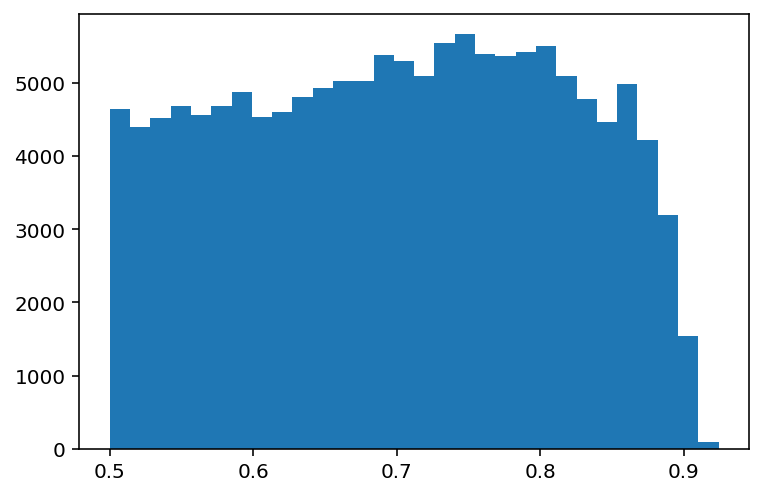

In [73]:
l2g_scores = [y for x in bestgenes_df.bestLocus2Genes_score for y in x]
plt.hist(l2g_scores, bins=30);

In [74]:
np.nanmax(l2g_scores)

0.9243353605270386

In [75]:
l2g_max_scores = [np.nanmax(x) if x else np.nan for x in bestgenes_df.bestLocus2Genes_score]

In [76]:
max_study_idx = np.nanargmax(l2g_max_scores)

In [77]:
bestgenes_df.iloc[[max_study_idx]]

,study,bestGenes_id,bestGenes_symbol,bestColocGenes_id,bestColocGenes_symbol,bestLocus2Genes_id,bestLocus2Genes_symbol,bestLocus2Genes_score,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol,pvalMantissa,pvalExponent,credibleSetSize,ldSetSize,totalSetSize,pval,oddsRatio,oddsRatioCILower,oddsRatioCIUpper,beta,betaCILower,betaCIUpper,direction,variant_chromosome,variant_position,variant_refAllele,variant_altAllele,variant_rsId,variant_chromosomeB37,variant_positionB37,variant_id,variant_nearestGene,variant_nearestGeneDistance,variant_nearestCodingGene,variant_nearestCodingGeneDistance,variant_mostSevereConsequence,variant_caddRaw,variant_caddPhred,variant_gnomadAFR,variant_gnomadAMR,variant_gnomadASJ,variant_gnomadEAS,variant_gnomadFIN,variant_gnomadNFE,variant_gnomadNFEEST,variant_gnomadNFENWE,variant_gnomadNFESEU,variant_gnomadNFEONF,variant_gnomadOTH,variant_nearestGene_id,variant_nearestGene_symbol,variant_nearestGene_bioType,variant_nearestGene_description,variant_nearestGene_chromosome,variant_nearestGene_tss,variant_nearestGene_start,variant_nearestGene_end,variant_nearestGene_fwdStrand,variant_nearestGene_exons,variant_nearestCodingGene_id,variant_nearestCodingGene_symbol,variant_nearestCodingGene_bioType,variant_nearestCodingGene_description,variant_nearestCodingGene_chromosome,variant_nearestCodingGene_tss,variant_nearestCodingGene_start,variant_nearestCodingGene_end,variant_nearestCodingGene_fwdStrand,variant_nearestCodingGene_exons
190695,NEALE2_23119_raw,"(ENSG00000038427,)","(VCAN,)","(ENSG00000038427,)","(VCAN,)","(ENSG00000038427,)","(VCAN,)","(0.9243353605270386,)","(ENSG00000038427,)","(VCAN,)",2.5618,-9,4,4,4,2.561800e-09,None,None,None,-0.265494,-0.352839,-0.178149,-,5,83515065,T,C,rs34580448,5,82810884,5_83515065_T_C,NaN,43447,NaN,43447,intron_variant,-0.208701,0.675,0.006884,0.030733,0.055172,0,0.017271,0.036038,0.027233,0.039437,0.009434,0.042603,0.027574,ENSG00000038427,VCAN,protein_coding,versican [Source:HGNC Symbol;Acc:HGNC:2464],5,83471618.0,83471618.0,83582303.0,True,"[83471744, 83472023, 83490098, 83490472, 83483...",ENSG00000038427,VCAN,protein_coding,versican [Source:HGNC Symbol;Acc:HGNC:2464],5,83471618.0,83471618.0,83582303.0,True,"[83471744, 83472023, 83490098, 83490472, 83483..."


In [78]:
bestgenes_df

,study,bestGenes_id,bestGenes_symbol,bestColocGenes_id,bestColocGenes_symbol,bestLocus2Genes_id,bestLocus2Genes_symbol,bestLocus2Genes_score,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol,pvalMantissa,pvalExponent,credibleSetSize,ldSetSize,totalSetSize,pval,oddsRatio,oddsRatioCILower,oddsRatioCIUpper,beta,betaCILower,betaCIUpper,direction,variant_chromosome,variant_position,variant_refAllele,variant_altAllele,variant_rsId,variant_chromosomeB37,variant_positionB37,variant_id,variant_nearestGene,variant_nearestGeneDistance,variant_nearestCodingGene,variant_nearestCodingGeneDistance,variant_mostSevereConsequence,variant_caddRaw,variant_caddPhred,variant_gnomadAFR,variant_gnomadAMR,variant_gnomadASJ,variant_gnomadEAS,variant_gnomadFIN,variant_gnomadNFE,variant_gnomadNFEEST,variant_gnomadNFENWE,variant_gnomadNFESEU,variant_gnomadNFEONF,variant_gnomadOTH,variant_nearestGene_id,variant_nearestGene_symbol,variant_nearestGene_bioType,variant_nearestGene_description,variant_nearestGene_chromosome,variant_nearestGene_tss,variant_nearestGene_start,variant_nearestGene_end,variant_nearestGene_fwdStrand,variant_nearestGene_exons,variant_nearestCodingGene_id,variant_nearestCodingGene_symbol,variant_nearestCodingGene_bioType,variant_nearestCodingGene_description,variant_nearestCodingGene_chromosome,variant_nearestCodingGene_tss,variant_nearestCodingGene_start,variant_nearestCodingGene_end,variant_nearestCodingGene_fwdStrand,variant_nearestCodingGene_exons
0,FINNGEN_R5_AB1_GHLAMY_OTHER,(),(),(),(),"(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)","(0.6906188130378723, 0.5723833441734314)","(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)",2.015,-8,2,0,2,2.015000e-08,7938577976.443386,2763395.679138,22805644795582.570312,None,None,None,+,6,46877116,T,G,None,None,None,6_46877116_T_G,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FINNGEN_R5_AB1_MEASLES,"(ENSG00000273396, ENSG00000163132)","(LINC01396, MSX1)",(),(),"(ENSG00000163132,)","(MSX1,)","(0.6779915690422058,)","(ENSG00000163132,)","(MSX1,)",4.990,-8,2,13,13,4.990000e-08,0.552501,0.446371,0.683865,None,None,None,-,4,4864861,A,C,rs6825765,4,4866588,4_4864861_A_C,NaN,5196,NaN,5196,downstream_gene_variant,0.129132,4.745,0.468369,0.612028,0.375862,0.652706,0.601729,0.464031,0.508534,0.448545,0.443396,0.432116,0.48893,ENSG00000163132,MSX1,protein_coding,msh homeobox 1 [Source:HGNC Symbol;Acc:HGNC:7391],4,4859665.0,4859665.0,4863936.0,True,"[4862701, 4863936, 4859665, 4860368]",ENSG00000163132,MSX1,protein_coding,msh homeobox 1 [Source:HGNC Symbol;Acc:HGNC:7391],4,4859665.0,4859665.0,4863936.0,True,"[4862701, 4863936, 4859665, 4860368]"
2,FINNGEN_R5_AB1_OTHER_BACTERIAL,"(ENSG00000132693,)","(CRP,)",(),(),"(ENSG00000132693,)","(CRP,)","(0.6587790846824646,)","(ENSG00000132693,)","(CRP,)",6.133,-10,3,4,4,6.133000e-10,0.874765,0.838461,0.912641,None,None,None,-,1,159743672,A,G,rs74596724,1,159713462,1_159743672_A_G,NaN,29083,NaN,29083,intergenic_variant,0.770176,11.64,0.011703,0.040094,0.096552,0.164103,0.063364,0.075765,0.096288,0.067939,0.09434,0.062324,0.0625,ENSG00000132693,CRP,protein_coding,C-reactive protein [Source:HGNC Symbol;Acc:HGN...,1,159714589.0,159712289.0,159714589.0,False,"[159714425, 159714589, 159712289, 159714138]",ENSG00000132693,CRP,protein_coding,C-reactive protein [Source:HGNC Symbol;Acc:HGN...,1,159714589.0,159712289.0,159714589.0,False,"[159714425, 159714589, 159712289, 159714138]"
3,FINNGEN_R5_AB1_OTHER_BACTERIAL,"(ENSG00000235532,)","(LINC00402,)",(),(),"(ENSG00000118922,)","(KLF12,)","(0.8585225939750671,)","(ENSG00000118922,)","(KLF12,)",4.023,-8,8,0,8,4.023000e-08,1.997507,1.560296,2.55723,None,None,None,+,13,74291635,C,T,rs117832616,13,74865772,13_74291635_C_T,NaN,60178,NaN,296579,upstream_gene_variant,-0.24534,0.528,0,0.002358,0,0.010296,0.003165,0.000519,0.001093,0.000116,0,0.000935,0,ENSG00000235532,LINC00402,lincRNA,lon

In [79]:
sorted(info_df.traitCategory.unique())

['Uncategorised',
 'biological process',
 'cardiovascular disease',
 'cell proliferation disorder',
 'disease of ear',
 'disease of visual system',
 'endocrine system disease',
 'gastrointestinal disease',
 'genetic, familial or congenital disease',
 'hematologic disease',
 'immune system disease',
 'infectious disease',
 'injury, poisoning or other complication',
 'integumentary system disease',
 'measurement',
 'musculoskeletal or connective tissue disease',
 'nervous system disease',
 'nutritional or metabolic disease',
 'pancreas disease',
 'phenotype',
 'pregnancy or perinatal disease',
 'psychiatric disorder',
 'reproductive system or breast disease',
 'respiratory or thoracic disease',
 'urinary system disease']

## Add L2G and closest gene  info to info data frame as a list

In [80]:
bestgenes_df.set_index('study', inplace=True)
info_df.set_index('studyId', inplace=True)

In [81]:
bestgenes_df['variant_bestLocus2GenesOrClosest_symbol'] = list(zip(bestgenes_df.bestLocus2GenesOrClosest_symbol, bestgenes_df.variant_id))
bestgenes_df['variant_bestLocus2GenesOrClosest_id'] = list(zip(bestgenes_df.bestLocus2GenesOrClosest_id, bestgenes_df.variant_id))

bestgenes_df[['bestLocus2GenesOrClosest_id', 'bestLocus2GenesOrClosest_symbol', 'variant_id', 'variant_bestLocus2GenesOrClosest_symbol', 'variant_bestLocus2GenesOrClosest_id']]

,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol,variant_id,variant_bestLocus2GenesOrClosest_symbol,variant_bestLocus2GenesOrClosest_id
study,,,,,
FINNGEN_R5_AB1_GHLAMY_OTHER,"(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)",6_46877116_T_G,"((MEP1A, ADGRF5), 6_46877116_T_G)","((ENSG00000112818, ENSG00000069122), 6_4687711..."
FINNGEN_R5_AB1_MEASLES,"(ENSG00000163132,)","(MSX1,)",4_4864861_A_C,"((MSX1,), 4_4864861_A_C)","((ENSG00000163132,), 4_4864861_A_C)"
FINNGEN_R5_AB1_OTHER_BACTERIAL,"(ENSG00000132693,)","(CRP,)",1_159743672_A_G,"((CRP,), 1_159743672_A_G)","((ENSG00000132693,), 1_159743672_A_G)"
FINNGEN_R5_AB1_OTHER_BACTERIAL,"(ENSG00000118922,)","(KLF12,)",13_74291635_C_T,"((KLF12,), 13_74291635_C_T)","((ENSG00000118922,), 13_74291635_C_T)"
FINNGEN_R5_AB1_OTHER_CHLAMYDIAE,"(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)",6_46877116_T_G,"((MEP1A, ADGRF5), 6_46877116_T_G)","((ENSG00000112818, ENSG00000069122), 6_4687711..."
...,...,...,...,...,...
SAIGE_960_2,"(ENSG00000188981,)","(MSANTD1,)",4_3240118_C_T,"((MSANTD1,), 4_3240118_C_T)","((ENSG00000188981,), 4_3240118_C_T)"
SAIGE_965,"(ENSG00000145839,)","(IL9,)",5_135834716_T_G,"((IL9,), 5_135834716_T_G)","((ENSG00000145839,), 5_135834716_T_G)"
SAIGE_965_1,"(ENSG00000152495,)","(CAMK4,)",5_111211885_A_G,"((CAMK4,), 5_111211885_A_G)","((ENSG00000152495,), 5_111211885_A_G)"


In [82]:
bestgenes_df.groupby('study')[['bestLocus2GenesOrClosest_id', 'bestLocus2GenesOrClosest_symbol']].agg(lambda x: tuple([i for y in x for i in y]))

,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol
study,,
FINNGEN_R5_AB1_GHLAMY_OTHER,"(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)"
FINNGEN_R5_AB1_MEASLES,"(ENSG00000163132,)","(MSX1,)"
FINNGEN_R5_AB1_OTHER_BACTERIAL,"(ENSG00000132693, ENSG00000118922)","(CRP, KLF12)"
FINNGEN_R5_AB1_OTHER_CHLAMYDIAE,"(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)"
FINNGEN_R5_AB1_OTHER_SPIROCHAETAL,"(ENSG00000135316,)","(SYNCRIP,)"
...,...,...
SAIGE_960_2,"(ENSG00000188981,)","(MSANTD1,)"
SAIGE_965,"(ENSG00000145839,)","(IL9,)"
SAIGE_965_1,"(ENSG00000152495,)","(CAMK4,)"


In [83]:
info_df = info_df.join(bestgenes_df.groupby('study')[['bestLocus2GenesOrClosest_id', 'bestLocus2GenesOrClosest_symbol']].agg(lambda x: tuple([i for y in x for i in y])), how='left')
info_df

,traitReported,source,traitEfos,pmid,pubDate,pubJournal,pubTitle,pubAuthor,hasSumstats,ancestryInitial,ancestryReplication,nInitial,nReplication,nCases,traitCategory,numAssocLoci,nTotal,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol
studyId,,,,,,,,,,,,,,,,,,,
FINNGEN_R5_AB1_BACTINF_NOS,"""Bacterial infection, other or unspecified""",FINNGEN,[EFO_0000771],None,2021-05-11,None,None,FINNGEN_R5,True,[European=218637],[],218637,0,20977,infectious disease,2,218637,NaN,NaN
FINNGEN_R5_AB1_DERMATOPHYTOSIS,Dermatophytosis,FINNGEN,[MONDO_0004678],None,2021-05-11,None,None,FINNGEN_R5,True,[European=216472],[],216472,0,1656,infectious disease,1,216472,NaN,NaN
FINNGEN_R5_AB1_EBV,Infectious mononucleosis,FINNGEN,[EFO_0007326],None,2021-05-11,None,None,FINNGEN_R5,True,[European=214904],[],214904,0,1238,infectious disease,1,214904,NaN,NaN
FINNGEN_R5_AB1_GASTROENTERITIS_NOS,Diarrhoea and gastroenteritis of presumed infe...,FINNGEN,[MONDO_0045031],None,2021-05-11,None,None,FINNGEN_R5,True,[European=212553],[],212553,0,15255,infectious disease,1,212553,NaN,NaN
FINNGEN_R5_AB1_GHLAMY_OTHER,Other diseases caused by chlamydiae,FINNGEN,[EFO_1001288],None,2021-05-11,None,None,FINNGEN_R5,True,[European=218772],[],218772,0,167,infectious disease,1,218772,"(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAIGE_960_2,Allergy/adverse effect of penicillin,SAIGE,[EFO_0008546],None,2018-10-24,None,None,UKB SAIGE,True,[European=397887],[],397887,0,16090,"injury, poisoning or other complication",1,397887,"(ENSG00000188981,)","(MSANTD1,)"
SAIGE_965,"Poisoning by analgesics, antipyretics, and ant...",SAIGE,[EFO_0008546],None,2018-10-24,None,None,UKB SAIGE,True,[European=388707],[],388707,0,6910,"injury, poisoning or other complication",1,388707,"(ENSG00000145839,)","(IL9,)"
SAIGE_965_1,Opiates and related narcotics causing adverse ...,SAIGE,[EFO_0009658],None,2018-10-24,None,None,UKB SAIGE,True,[European=382947],[],382947,0,1150,"injury, poisoning or other complication",1,382947,"(ENSG00000152495,)","(CAMK4,)"


In [84]:
info_df['variant_gene_id_pairs'] = bestgenes_df.groupby('study')[['variant_bestLocus2GenesOrClosest_id']].agg(tuple)
info_df['variant_gene_symbol_pairs'] = bestgenes_df.groupby('study')[['variant_bestLocus2GenesOrClosest_symbol']].agg(tuple)

In [85]:
info_df

,traitReported,source,traitEfos,pmid,pubDate,pubJournal,pubTitle,pubAuthor,hasSumstats,ancestryInitial,ancestryReplication,nInitial,nReplication,nCases,traitCategory,numAssocLoci,nTotal,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol,variant_gene_id_pairs,variant_gene_symbol_pairs
studyId,,,,,,,,,,,,,,,,,,,,,
FINNGEN_R5_AB1_BACTINF_NOS,"""Bacterial infection, other or unspecified""",FINNGEN,[EFO_0000771],None,2021-05-11,None,None,FINNGEN_R5,True,[European=218637],[],218637,0,20977,infectious disease,2,218637,NaN,NaN,NaN,NaN
FINNGEN_R5_AB1_DERMATOPHYTOSIS,Dermatophytosis,FINNGEN,[MONDO_0004678],None,2021-05-11,None,None,FINNGEN_R5,True,[European=216472],[],216472,0,1656,infectious disease,1,216472,NaN,NaN,NaN,NaN
FINNGEN_R5_AB1_EBV,Infectious mononucleosis,FINNGEN,[EFO_0007326],None,2021-05-11,None,None,FINNGEN_R5,True,[European=214904],[],214904,0,1238,infectious disease,1,214904,NaN,NaN,NaN,NaN
FINNGEN_R5_AB1_GASTROENTERITIS_NOS,Diarrhoea and gastroenteritis of presumed infe...,FINNGEN,[MONDO_0045031],None,2021-05-11,None,None,FINNGEN_R5,True,[European=212553],[],212553,0,15255,infectious disease,1,212553,NaN,NaN,NaN,NaN
FINNGEN_R5_AB1_GHLAMY_OTHER,Other diseases caused by chlamydiae,FINNGEN,[EFO_1001288],None,2021-05-11,None,None,FINNGEN_R5,True,[European=218772],[],218772,0,167,infectious disease,1,218772,"(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)","(((ENSG00000112818, ENSG00000069122), 6_468771...","(((MEP1A, ADGRF5), 6_46877116_T_G),)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAIGE_960_2,Allergy/adverse effect of penicillin,SAIGE,[EFO_0008546],None,2018-10-24,None,None,UKB SAIGE,True,[European=397887],[],397887,0,16090,"injury, poisoning or other complication",1,397887,"(ENSG00000188981,)","(MSANTD1,)","(((ENSG00000188981,), 4_3240118_C_T),)","(((MSANTD1,), 4_3240118_C_T),)"
SAIGE_965,"Poisoning by analgesics, antipyretics, and ant...",SAIGE,[EFO_0008546],None,2018-10-24,None,None,UKB SAIGE,True,[European=388707],[],388707,0,6910,"injury, poisoning or other complication",1,388707,"(ENSG00000145839,)","(IL9,)","(((ENSG00000145839,), 5_135834716_T_G),)","(((IL9,), 5_135834716_T_G),)"
SAIGE_965_1,Opiates and related narcotics causing adverse ...,SAIGE,[EFO_0009658],None,2018-10-24,None,None,UKB SAIGE,True,[European=382947],[],382947,0,1150,"injury, poisoning or other complication",1,382947,"(ENSG00000152495,)","(CAMK4,)","(((ENSG00000152495,), 5_111211885_A_G),)","(((CAMK4,), 5_111211885_A_G),)"


## Remove duplicates in gene lists using the ids as reference

In [86]:
duplicates = [pd.Series(x).duplicated() + pd.Series(x).isnull() for x in info_df.bestLocus2GenesOrClosest_id]

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [87]:
info_df['bestLocus2GenesOrClosest_id'] = [tuple(np.array(i)[~dup]) if not pd.isnull(i) and i != 'nan' else i for dup, i in zip(duplicates, info_df['bestLocus2GenesOrClosest_id'])]
info_df['bestLocus2GenesOrClosest_symbol'] = [tuple(np.array(i)[~dup]) if not pd.isnull(i) and i != 'nan' else i for dup, i in zip(duplicates, info_df['bestLocus2GenesOrClosest_symbol'])]

In [88]:
'nan' in info_df[~info_df.bestLocus2GenesOrClosest_id.isnull()].explode('bestLocus2GenesOrClosest_id').bestLocus2GenesOrClosest_id.unique()

False

In [89]:
assert info_df[~info_df.bestLocus2GenesOrClosest_id.isnull()].explode('bestLocus2GenesOrClosest_id').bestLocus2GenesOrClosest_id.isna().sum() == 0

In [90]:
info_df.traitReported = info_df.traitReported.str.replace('"', '').str.replace('Õ', "'").str.replace('Ê', '') # Sanitize FINNGEN trait names until https://github.com/FINNGEN/pheweb/issues/142 is fixed

In [91]:
assert np.all([len(x) if not pd.isnull(x) else 0 for x in info_df['bestLocus2GenesOrClosest_id']] == [len(x) if not pd.isnull(x) else 0 for x in info_df['bestLocus2GenesOrClosest_symbol']])

## Sanity check

In [92]:
bestgenes_df.loc['GCST006434_9'][[
    'bestLocus2Genes_id', 
    'variant_nearestCodingGene_id', 
    'bestLocus2Genes_symbol',
    'variant_nearestCodingGene_symbol', 
    'bestLocus2GenesOrClosest_id', 
    'bestLocus2GenesOrClosest_symbol', 
    'variant_bestLocus2GenesOrClosest_symbol',
    'variant_bestLocus2GenesOrClosest_id',
]]

,bestLocus2Genes_id,variant_nearestCodingGene_id,bestLocus2Genes_symbol,variant_nearestCodingGene_symbol,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol,variant_bestLocus2GenesOrClosest_symbol,variant_bestLocus2GenesOrClosest_id
study,,,,,,,,
GCST006434_9,"(ENSG00000130940,)",ENSG00000130940,"(CASZ1,)",CASZ1,"(ENSG00000130940,)","(CASZ1,)","((CASZ1,), 1_10737371_G_GC)","((ENSG00000130940,), 1_10737371_G_GC)"
GCST006434_9,"(ENSG00000215910,)",ENSG00000215910,"(C1orf167,)",C1orf167,"(ENSG00000215910,)","(C1orf167,)","((C1orf167,), 1_11779866_C_T)","((ENSG00000215910,), 1_11779866_C_T)"
GCST006434_9,"(ENSG00000171303,)",ENSG00000171303,"(KCNK3,)",KCNK3,"(ENSG00000171303,)","(KCNK3,)","((KCNK3,), 2_26709928_C_T)","((ENSG00000171303,), 2_26709928_C_T)"
GCST006434_9,(),ENSG00000182263,(),FIGN,"(ENSG00000182263,)","(FIGN,)","((FIGN,), 2_164151656_C_G)","((ENSG00000182263,), 2_164151656_C_G)"
GCST006434_9,"(ENSG00000163491,)",ENSG00000163491,"(NEK10,)",NEK10,"(ENSG00000163491,)","(NEK10,)","((NEK10,), 3_27322446_T_A)","((ENSG00000163491,), 3_27322446_T_A)"
GCST006434_9,"(ENSG00000033867,)",ENSG00000033867,"(SLC4A7,)",SLC4A7,"(ENSG00000033867,)","(SLC4A7,)","((SLC4A7,), 3_27521497_C_T)","((ENSG00000033867,), 3_27521497_C_T)"
GCST006434_9,"(ENSG00000085276,)",ENSG00000085276,"(MECOM,)",MECOM,"(ENSG00000085276,)","(MECOM,)","((MECOM,), 3_169379112_C_T)","((ENSG00000085276,), 3_169379112_C_T)"
GCST006434_9,"(ENSG00000138675,)",ENSG00000138675,"(FGF5,)",FGF5,"(ENSG00000138675,)","(FGF5,)","((FGF5,), 4_80246155_C_T)","((ENSG00000138675,), 4_80246155_C_T)"
GCST006434_9,"(ENSG00000164116,)",ENSG00000061918,"(GUCY1A1,)",GUCY1B1,"(ENSG00000164116,)","(GUCY1A1,)","((GUCY1A1,), 4_155724361_C_A)","((ENSG00000164116,), 4_155724361_C_A)"


## Save objects

In [93]:
'nan' in info_df[~info_df.bestLocus2GenesOrClosest_id.isnull()].explode('bestLocus2GenesOrClosest_id').bestLocus2GenesOrClosest_id.unique()

False

In [94]:
info_df

,traitReported,source,traitEfos,pmid,pubDate,pubJournal,pubTitle,pubAuthor,hasSumstats,ancestryInitial,ancestryReplication,nInitial,nReplication,nCases,traitCategory,numAssocLoci,nTotal,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol,variant_gene_id_pairs,variant_gene_symbol_pairs
studyId,,,,,,,,,,,,,,,,,,,,,
FINNGEN_R5_AB1_BACTINF_NOS,"Bacterial infection, other or unspecified",FINNGEN,[EFO_0000771],None,2021-05-11,None,None,FINNGEN_R5,True,[European=218637],[],218637,0,20977,infectious disease,2,218637,NaN,NaN,NaN,NaN
FINNGEN_R5_AB1_DERMATOPHYTOSIS,Dermatophytosis,FINNGEN,[MONDO_0004678],None,2021-05-11,None,None,FINNGEN_R5,True,[European=216472],[],216472,0,1656,infectious disease,1,216472,NaN,NaN,NaN,NaN
FINNGEN_R5_AB1_EBV,Infectious mononucleosis,FINNGEN,[EFO_0007326],None,2021-05-11,None,None,FINNGEN_R5,True,[European=214904],[],214904,0,1238,infectious disease,1,214904,NaN,NaN,NaN,NaN
FINNGEN_R5_AB1_GASTROENTERITIS_NOS,Diarrhoea and gastroenteritis of presumed infe...,FINNGEN,[MONDO_0045031],None,2021-05-11,None,None,FINNGEN_R5,True,[European=212553],[],212553,0,15255,infectious disease,1,212553,NaN,NaN,NaN,NaN
FINNGEN_R5_AB1_GHLAMY_OTHER,Other diseases caused by chlamydiae,FINNGEN,[EFO_1001288],None,2021-05-11,None,None,FINNGEN_R5,True,[European=218772],[],218772,0,167,infectious disease,1,218772,"(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)","(((ENSG00000112818, ENSG00000069122), 6_468771...","(((MEP1A, ADGRF5), 6_46877116_T_G),)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAIGE_960_2,Allergy/adverse effect of penicillin,SAIGE,[EFO_0008546],None,2018-10-24,None,None,UKB SAIGE,True,[European=397887],[],397887,0,16090,"injury, poisoning or other complication",1,397887,"(ENSG00000188981,)","(MSANTD1,)","(((ENSG00000188981,), 4_3240118_C_T),)","(((MSANTD1,), 4_3240118_C_T),)"
SAIGE_965,"Poisoning by analgesics, antipyretics, and ant...",SAIGE,[EFO_0008546],None,2018-10-24,None,None,UKB SAIGE,True,[European=388707],[],388707,0,6910,"injury, poisoning or other complication",1,388707,"(ENSG00000145839,)","(IL9,)","(((ENSG00000145839,), 5_135834716_T_G),)","(((IL9,), 5_135834716_T_G),)"
SAIGE_965_1,Opiates and related narcotics causing adverse ...,SAIGE,[EFO_0009658],None,2018-10-24,None,None,UKB SAIGE,True,[European=382947],[],382947,0,1150,"injury, poisoning or other complication",1,382947,"(ENSG00000152495,)","(CAMK4,)","(((ENSG00000152495,), 5_111211885_A_G),)","(((CAMK4,), 5_111211885_A_G),)"


In [95]:
info_df.to_pickle('data/info.pkl')
bestgenes_df.to_pickle('data/bestgenes.pkl')